In [1]:
import ast
import numpy as np
import pandas as pd
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image
import torch.optim as optim
from transformers import AutoModel, AutoTokenizer, CLIPModel, CLIPProcessor
from tqdm import tqdm
from torchvision.transforms.functional import to_pil_image
from torch.utils.tensorboard import SummaryWriter

/home/ptyagi/miniconda3/envs/thesis_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-26 15:25:28.243259: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1735223128.260111 1881414 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1735223128.265319 1881414 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-26 15:25:28.287353: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performan

In [2]:
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

In [3]:
class MLPForCombinedPredictions(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_labels):
        super(MLPForCombinedPredictions, self).__init__()
        torch.manual_seed(42)
        torch.cuda.manual_seed_all(42)
        self.mlp = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_labels),
            nn.Softmax(dim=-1)  
        )
    
    def forward(self, x):
        return self.mlp(x)

In [4]:
class EmotionDataset(Dataset):
    def __init__(self, data):
        """
        Args:
            data: DataFrame containing the data.
        """
        self.data = data
        self.label_order = ['fear', 'disgust', 'joy', 'surprise', 'sadness', 'anger']

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]

        def extract_probs(column):
            prob_dict = dict(ast.literal_eval(row[column]))
            return [prob_dict[label] for label in self.label_order]

        image_probs = torch.tensor(extract_probs('clip_predictions'), dtype=torch.float32)
        text_probs = torch.tensor(extract_probs('mapped_predictions'), dtype=torch.float32)
        labels = torch.tensor(extract_probs('averaged_predictions'), dtype=torch.float32)

        combined_features = torch.cat((image_probs, text_probs), dim=0)
        return combined_features, labels

In [5]:
def train_mlp(model, dataloader, optimizer, criterion, device, writer=None, epoch=None):
    model.train()
    total_loss = 0
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1} - Training" if epoch is not None else "Training")
    
    for features, labels in progress_bar:
        features, labels = features.to(device), labels.to(device)
        
        optimizer.zero_grad()
        predictions = model(features)
        loss = criterion(torch.log(predictions), labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
        progress_bar.set_postfix(loss=loss.item())
    
    avg_loss = total_loss / len(dataloader)
    # Log training loss to TensorBoard
    if writer and epoch is not None:
        writer.add_scalar("Loss/Train", avg_loss, epoch)
    return avg_loss

def evaluate_model(model, dataloader, device):
    model.eval()
    total_kl_div = 0.0
    total_cosine_sim = 0.0
    total_mse = 0.0
    num_samples = 0

    with torch.no_grad():
        for features, labels in dataloader:
            features, labels = features.to(device), labels.to(device)
            predictions = model(features)

            total_kl_div += F.kl_div(torch.log(predictions), labels, reduction='batchmean').item() * len(features)
            total_cosine_sim += F.cosine_similarity(predictions, labels, dim=-1).mean().item() * len(features)
            total_mse += F.mse_loss(predictions, labels, reduction='mean').item() * len(features)
            num_samples += len(features)

    avg_kl_div = total_kl_div / num_samples
    avg_cosine_sim = total_cosine_sim / num_samples
    avg_mse = total_mse / num_samples

    return avg_kl_div, avg_cosine_sim, avg_mse

def plot_cosine_similarity_kde(predictions, labels):
    """
    Compute and visualize the distribution of cosine similarities using a KDE plot.
    Args:
        predictions: Tensor of predicted probabilities (batch_size, num_labels).
        labels: Tensor of true probabilities (batch_size, num_labels).
    """
    similarities = F.cosine_similarity(predictions, labels, dim=-1).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    sns.kdeplot(similarities, fill=True, color="blue")
    plt.title("Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.axvline(x=1.0, color='green', linestyle='--', label='Perfect Similarity')
    plt.legend()
    plt.show()



In [6]:
def plot_label_wise_heatmap(predictions, labels, label_order):
    """
    Plot a heatmap comparing average predicted vs actual probabilities for each label.
    """
    avg_pred = predictions.mean(dim=0).detach().cpu().numpy()
    avg_label = labels.mean(dim=0).cpu().numpy()

    heatmap_data = np.vstack([avg_label, avg_pred])
    labels = ["True", "Predicted"]

    plt.figure(figsize=(10, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=label_order, yticklabels=labels)
    plt.title("Label-Wise Average Probabilities")
    plt.xlabel("Labels")
    plt.ylabel("Distribution")
    plt.show()

In [7]:
def print_random_predictions(predictions, labels, label_order, num_samples=5):
    """
    Print a few random predictions and their corresponding true labels.
    Args:
        predictions: Tensor of predicted probabilities (batch_size, num_labels).
        labels: Tensor of true probabilities (batch_size, num_labels).
        label_order: List of labels in the correct order.
        num_samples: Number of random samples to display.
    """
    predictions = predictions.detach().cpu().numpy()
    labels = labels.cpu().numpy()

    indices = random.sample(range(len(predictions)), num_samples)

    for idx in indices:
        print(f"Sample {idx + 1}")
        print("True Labels:")
        for label, prob in zip(label_order, labels[idx]):
            print(f"  {label}: {prob:.4f}")
        print("Predicted Labels:")
        for label, prob in zip(label_order, predictions[idx]):
            print(f"  {label}: {prob:.4f}")
        print("-" * 40)

Epoch 1 - Training: 100%|██████████| 37/37 [00:00<00:00, 51.83it/s, loss=0.393]


Epoch 1/10, Train Loss: 0.4564, Validation KL Divergence: 0.3858


Epoch 2 - Training: 100%|██████████| 37/37 [00:00<00:00, 53.69it/s, loss=0.259]


Epoch 2/10, Train Loss: 0.3770, Validation KL Divergence: 0.3453


Epoch 3 - Training: 100%|██████████| 37/37 [00:00<00:00, 81.62it/s, loss=0.452]


Epoch 3/10, Train Loss: 0.3605, Validation KL Divergence: 0.3390


Epoch 4 - Training: 100%|██████████| 37/37 [00:00<00:00, 69.55it/s, loss=0.388]


Epoch 4/10, Train Loss: 0.3513, Validation KL Divergence: 0.3390


Epoch 5 - Training: 100%|██████████| 37/37 [00:00<00:00, 69.34it/s, loss=0.309]


Epoch 5/10, Train Loss: 0.3501, Validation KL Divergence: 0.3407


Epoch 6 - Training: 100%|██████████| 37/37 [00:00<00:00, 69.67it/s, loss=0.343]


Epoch 6/10, Train Loss: 0.3455, Validation KL Divergence: 0.3405


Epoch 7 - Training: 100%|██████████| 37/37 [00:00<00:00, 76.10it/s, loss=0.316]


Epoch 7/10, Train Loss: 0.3458, Validation KL Divergence: 0.3387


Epoch 8 - Training: 100%|██████████| 37/37 [00:00<00:00, 65.97it/s, loss=0.266]


Epoch 8/10, Train Loss: 0.3451, Validation KL Divergence: 0.3394


Epoch 9 - Training: 100%|██████████| 37/37 [00:00<00:00, 67.99it/s, loss=0.309]


Epoch 9/10, Train Loss: 0.3449, Validation KL Divergence: 0.3389


Epoch 10 - Training: 100%|██████████| 37/37 [00:00<00:00, 77.46it/s, loss=0.228]


Epoch 10/10, Train Loss: 0.3434, Validation KL Divergence: 0.3390
Model saved to /work/ptyagi/masterthesis/src/models/multimodal_experiments_february/exp_mlp_lr1e-3_epochs10/mlp_training_lr1e-3_epochs10.pth
Test KL Divergence: 0.3301, Cosine Similarity: 0.8020, MSE: 0.0222
TensorBoard logs saved to /work/ptyagi/masterthesis/src/runs/february_exp/mlp_training_lr1e-3_epochs10


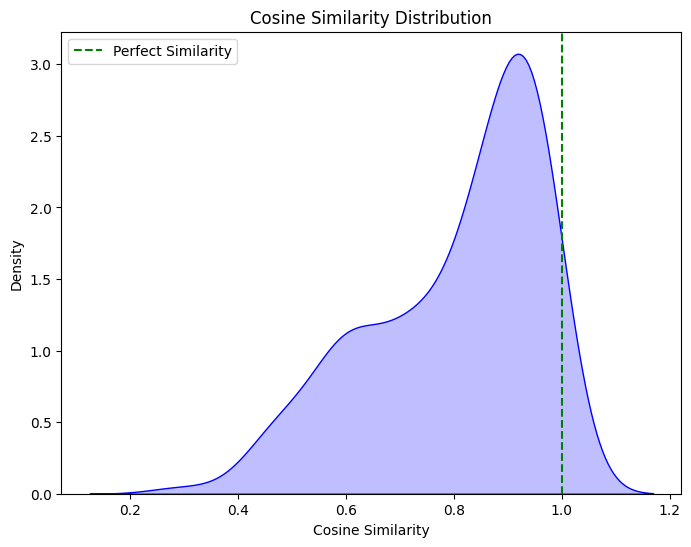

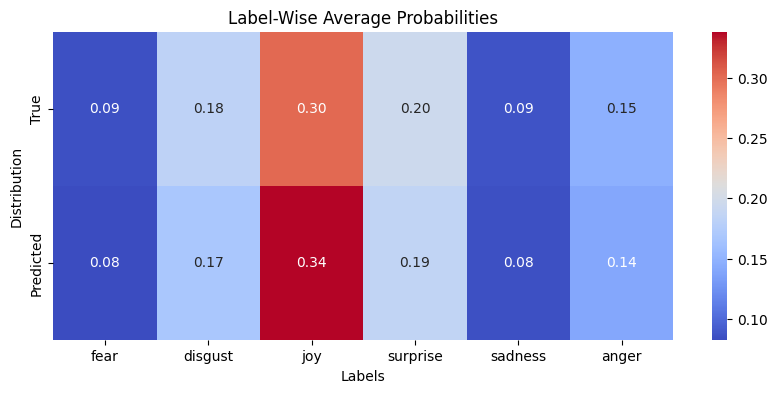

In [8]:
file_path = "/work/ptyagi/masterthesis/data/predictions/feb/averaged_predictions.csv" 

data = pd.read_csv(file_path)
    
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

train_dataset = EmotionDataset(train_data)
val_dataset = EmotionDataset(val_data)
test_dataset = EmotionDataset(test_data)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

num_labels = 6  
input_dim = num_labels * 2  
hidden_dim = 128

model = MLPForCombinedPredictions(input_dim=input_dim, hidden_dim=hidden_dim, num_labels=num_labels).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.KLDivLoss(reduction="batchmean")

# Initialize TensorBoard writer
log_dir = "/work/ptyagi/masterthesis/src/runs/february_exp/mlp_training_lr1e-3_epochs10"
writer = SummaryWriter(log_dir=log_dir)

# Training loop
epochs = 10
for epoch in range(epochs):
    # Train the model
    train_loss = train_mlp(model, train_loader, optimizer, criterion, device, writer, epoch)
    
    # Evaluate on validation set
    val_kl_div, val_cosine_sim, val_mse = evaluate_model(model, val_loader, device)
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation KL Divergence: {val_kl_div:.4f}")
    
    # Log validation metrics to TensorBoard
    writer.add_scalar("Loss/Val_KL_Div", val_kl_div, epoch)
    writer.add_scalar("Metrics/Val_Cosine_Sim", val_cosine_sim, epoch)
    writer.add_scalar("Metrics/Val_MSE", val_mse, epoch)

# Save the model
model_save_path = "/work/ptyagi/masterthesis/src/models/multimodal_experiments_february/exp_mlp_lr1e-3_epochs10/mlp_training_lr1e-3_epochs10.pth"
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Evaluate on test set
avg_kl_div, avg_cosine_sim, avg_mse = evaluate_model(model, test_loader, device)
print(f"Test KL Divergence: {avg_kl_div:.4f}, Cosine Similarity: {avg_cosine_sim:.4f}, MSE: {avg_mse:.4f}")

# Log test metrics to TensorBoard
writer.add_scalar("Test/KL_Div", avg_kl_div)
writer.add_scalar("Test/Cosine_Sim", avg_cosine_sim)
writer.add_scalar("Test/MSE", avg_mse)

# Close TensorBoard writer
writer.close()
print(f"TensorBoard logs saved to {log_dir}")

all_predictions = []
all_labels = []

for features, labels in test_loader:
    features, labels = features.to(device), labels.to(device)
    predictions = model(features)
    all_predictions.append(predictions)
    all_labels.append(labels)

all_predictions = torch.cat(all_predictions, dim=0)
all_labels = torch.cat(all_labels, dim=0)

plot_cosine_similarity_kde(all_predictions, all_labels)
plot_label_wise_heatmap(all_predictions, all_labels, train_dataset.label_order)


In [15]:
print_random_predictions(all_predictions, all_labels, train_dataset.label_order, num_samples=1)

Sample 128
True Labels:
  fear: 0.0752
  disgust: 0.2459
  joy: 0.1719
  surprise: 0.2501
  sadness: 0.0813
  anger: 0.1756
Predicted Labels:
  fear: 0.0979
  disgust: 0.2231
  joy: 0.2192
  surprise: 0.1808
  sadness: 0.0943
  anger: 0.1848
----------------------------------------


In [ ]:
# model = MLPForCombinedPredictions(input_dim=input_dim, hidden_dim=hidden_dim, num_labels=num_labels)
# model.load_state_dict(torch.load(model_save_path))
# model.to(device)
# model.eval() 

train clip and roberta

In [3]:
class MultiModalClassifier(nn.Module):
    def __init__(self, num_labels, hidden_dim=512):
        super(MultiModalClassifier, self).__init__()
        
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
        self.text_model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-emotion-latest")

        clip_feature_dim = self.clip_model.config.projection_dim  
        text_feature_dim = self.text_model.config.hidden_size
        combined_dim = clip_feature_dim + text_feature_dim

        self.mlp = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_labels)
        )

    def freeze_clip(self):
        """
        Freezes the CLIP model to prevent its parameters from being updated during training.
        """
        for param in self.clip_model.parameters():
            param.requires_grad = False

    def freeze_roberta(self):
        """
        Freezes the RoBERTa model to prevent its parameters from being updated during training.
        """
        for param in self.text_model.parameters():
            param.requires_grad = False

    def forward(self, image, input_ids, attention_mask):
        image_features = self.clip_model.get_image_features(image)

        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :] 

        combined_features = torch.cat([image_features, text_features], dim=-1)

        logits = self.mlp(combined_features)
        return logits

In [4]:
model = MultiModalClassifier(num_labels=6)

Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion-latest and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [5]:
model.to(device)

MultiModalClassifier(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=7

In [8]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {total_params}")

Number of trainable parameters: 553052167


In [3]:
class MultiModalDataset(Dataset):
    def __init__(self, data=None, csv_path=None, image_dir=None, label_col=None, image_col=None, text_col=None, clip_processor=None, roberta_tokenizer=None, max_length=512):
        if data is not None:
            self.data = data
        elif csv_path is not None:
            self.data = pd.read_csv(csv_path)
        else:
            raise ValueError("Either `data` or `csv_path` must be provided.")

        self.image_dir = image_dir
        self.label_col = label_col
        self.image_col = image_col
        self.text_col = text_col
        self.clip_processor = clip_processor
        self.tokenizer = roberta_tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_filename = self.data.iloc[idx][self.image_col]
        image_path = os.path.join(self.image_dir, image_filename)
        image = Image.open(image_path).convert("RGB")
        image = self.clip_processor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)

        text = self.data.iloc[idx][self.text_col]
        text_inputs = self.tokenizer(
            text, max_length=self.max_length, padding="max_length", truncation=True, return_tensors="pt"
        )

        label_tuples = eval(self.data.iloc[idx][self.label_col])  
        label_probs = [prob for _, prob in label_tuples]  
        label_tensor = torch.tensor(label_probs, dtype=torch.float)

        return {
            "image": image,
            "input_ids": text_inputs["input_ids"].squeeze(0),
            "attention_mask": text_inputs["attention_mask"].squeeze(0),
            "labels": label_tensor,
        }

In [5]:
clip_processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
roberta_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-emotion-latest")

csv_path = "/work/ptyagi/masterthesis/data/predictions/averaged_predictions.csv"

image_dir = "/work/ptyagi/ClimateVisions/Images/2019/02_February"

label_col = "averaged_predictions" 

text_col = "tweet_text" 

image_col = "matched_filename"

data = pd.read_csv(csv_path)

train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

train_dataset = MultiModalDataset(
    data=train_data,
    image_dir=image_dir,
    label_col=label_col,
    image_col=image_col,
    text_col=text_col,
    clip_processor=clip_processor,
    roberta_tokenizer=roberta_tokenizer
)

val_dataset = MultiModalDataset(
    data=val_data,
    image_dir=image_dir,
    label_col=label_col,
    image_col=image_col,
    text_col=text_col,
    clip_processor=clip_processor,
    roberta_tokenizer=roberta_tokenizer
)

test_dataset = MultiModalDataset(
    data=test_data,
    image_dir=image_dir,
    label_col=label_col,
    image_col=image_col,
    text_col=text_col,
    clip_processor=clip_processor,
    roberta_tokenizer=roberta_tokenizer
)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

criterion = nn.KLDivLoss(reduction="batchmean") 
optimizer = optim.Adam(model.parameters(), lr=1e-5)

/home/ptyagi/miniconda3/envs/thesis_env/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


NameError: name 'model' is not defined

In [13]:
def evaluate_model(model, dataloader, device):

    model.eval()
    total_kl_div = 0.0
    total_cosine_sim = 0.0
    total_mse = 0.0
    num_samples = 0

    with torch.no_grad():
        for batch in dataloader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            predictions = model(images, input_ids, attention_mask)
            predictions = torch.softmax(predictions, dim=-1)

            total_kl_div += F.kl_div(torch.log(predictions), labels, reduction='batchmean').item() * len(images)
            total_cosine_sim += F.cosine_similarity(predictions, labels, dim=-1).mean().item() * len(images)
            total_mse += F.mse_loss(predictions, labels, reduction='mean').item() * len(images)
            num_samples += len(images)

    avg_kl_div = total_kl_div / num_samples
    avg_cosine_sim = total_cosine_sim / num_samples
    avg_mse = total_mse / num_samples

    return avg_kl_div, avg_cosine_sim, avg_mse

In [16]:
def train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs, device, save_path=None, log_name=None):
    # Create a custom log directory name
    if log_name is None:
        log_name = f"experiment"
    writer = SummaryWriter(log_dir=f"runs/{log_name}")
    best_val_loss = float("inf")

    for epoch in range(epochs):
        model.train()
        total_train_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch + 1}/{epochs} - Training")

        for batch in progress_bar:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(images, input_ids, attention_mask)
            loss = criterion(torch.log_softmax(outputs, dim=-1), labels)

            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            progress_bar.set_postfix(loss=loss.item())

        avg_train_loss = total_train_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs} - Training Loss: {avg_train_loss:.4f}")

        # Log training loss to TensorBoard
        writer.add_scalar("Loss/Train", avg_train_loss, epoch)

        # Evaluate on validation set
        val_kl_div, val_cosine_sim, val_mse = evaluate_model(model, val_loader, device)
        print(f"Epoch {epoch + 1}/{epochs} - Validation Metrics - KL Div: {val_kl_div:.4f}, Cosine Sim: {val_cosine_sim:.4f}, MSE: {val_mse:.4f}")

        # Log validation metrics to TensorBoard
        writer.add_scalar("Loss/Val_KL_Div", val_kl_div, epoch)
        writer.add_scalar("Metrics/Val_Cosine_Sim", val_cosine_sim, epoch)
        writer.add_scalar("Metrics/Val_MSE", val_mse, epoch)

        # Save the best model
        if val_kl_div < best_val_loss:
            best_val_loss = val_kl_div
            if save_path:
                torch.save(model.state_dict(), save_path)
                print(f"Model saved at {save_path}")

    # Evaluate on test set
    test_kl_div, test_cosine_sim, test_mse = evaluate_model(model, test_loader, device)
    print(f"Test Metrics - KL Div: {test_kl_div:.4f}, Cosine Sim: {test_cosine_sim:.4f}, MSE: {test_mse:.4f}")

    # Log test metrics to TensorBoard
    writer.add_scalar("Test/KL_Div", test_kl_div)
    writer.add_scalar("Test/Cosine_Sim", test_cosine_sim)
    writer.add_scalar("Test/MSE", test_mse)

    # Close the TensorBoard writer
    writer.close()
    print(f"Logs saved to runs/{log_name}")


In [14]:
def save_initial_weights(model):
    initial_weights = {
        "clip": {name: param.clone() for name, param in model.clip_model.named_parameters()},
        "roberta": {name: param.clone() for name, param in model.text_model.named_parameters()}
    }
    return initial_weights

def compare_weights(initial_weights, model):
    weight_differences = {
        "clip": {name: (param - initial_weights["clip"][name]).norm().item()
                for name, param in model.clip_model.named_parameters()},
        "roberta": {name: (param - initial_weights["roberta"][name]).norm().item()
                    for name, param in model.text_model.named_parameters()}
    }
    return weight_differences

def plot_weight_updates(weight_differences, model_name):

    updates = list(weight_differences.values())
    plt.figure(figsize=(8, 6))
    plt.hist(updates, bins=50, alpha=0.7, color="blue")
    plt.title(f"Weight Updates for {model_name}")
    plt.xlabel("Weight Update Magnitude (L2 Norm)")
    plt.ylabel("Frequency")
    plt.show()

In [17]:
model.to(device)
initial_weights = save_initial_weights(model)

save_path = "/work/ptyagi/masterthesis/models/multimodal_models/best_multimodal_model_2epochs_base.pt"

train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=2, device=device, save_path=save_path, log_name="experiment_epochs2_full_base")

weight_differences = compare_weights(initial_weights, model)

Epoch 1/2 - Training: 100%|██████████| 147/147 [01:33<00:00,  1.57it/s, loss=0.334]


Epoch 1/2 - Training Loss: 0.3608
Epoch 1/2 - Validation Metrics - KL Div: 0.3400, Cosine Sim: 0.8200, MSE: 0.0222
Model saved at /work/ptyagi/masterthesis/models/multimodal_models/best_multimodal_model_2epochs_base.pt


Epoch 2/2 - Training: 100%|██████████| 147/147 [01:32<00:00,  1.58it/s, loss=0.846]


Epoch 2/2 - Training Loss: 0.3060
Epoch 2/2 - Validation Metrics - KL Div: 0.3411, Cosine Sim: 0.8152, MSE: 0.0225
Test Metrics - KL Div: 0.3437, Cosine Sim: 0.7929, MSE: 0.0232
Logs saved to runs/experiment_epochs2_full_base


In [23]:
model.to(device)
initial_weights = save_initial_weights(model)

save_path = "/work/ptyagi/masterthesis/models/multimodal_models/best_multimodal_model_4epochs_base.pt"

train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=4, device=device, save_path=save_path, log_name="experiment_epochs4_full_base")

weight_differences = compare_weights(initial_weights, model)

Epoch 1/4 - Training: 100%|██████████| 147/147 [01:32<00:00,  1.60it/s, loss=0.142]


Epoch 1/4 - Training Loss: 0.2809
Epoch 1/4 - Validation Metrics - KL Div: 0.3693, Cosine Sim: 0.8046, MSE: 0.0241
Model saved at /work/ptyagi/masterthesis/models/multimodal_models/best_multimodal_model_4epochs_base.pt


Epoch 2/4 - Training: 100%|██████████| 147/147 [01:32<00:00,  1.59it/s, loss=0.151]


Epoch 2/4 - Training Loss: 0.2263
Epoch 2/4 - Validation Metrics - KL Div: 0.4040, Cosine Sim: 0.7868, MSE: 0.0264


Epoch 3/4 - Training: 100%|██████████| 147/147 [01:32<00:00,  1.59it/s, loss=0.295] 


Epoch 3/4 - Training Loss: 0.1843
Epoch 3/4 - Validation Metrics - KL Div: 0.4062, Cosine Sim: 0.7879, MSE: 0.0262


Epoch 4/4 - Training: 100%|██████████| 147/147 [01:32<00:00,  1.59it/s, loss=0.153] 


Epoch 4/4 - Training Loss: 0.1482
Epoch 4/4 - Validation Metrics - KL Div: 0.4607, Cosine Sim: 0.7697, MSE: 0.0292
Test Metrics - KL Div: 0.4926, Cosine Sim: 0.7327, MSE: 0.0315
Logs saved to runs/experiment_epochs4_full_base


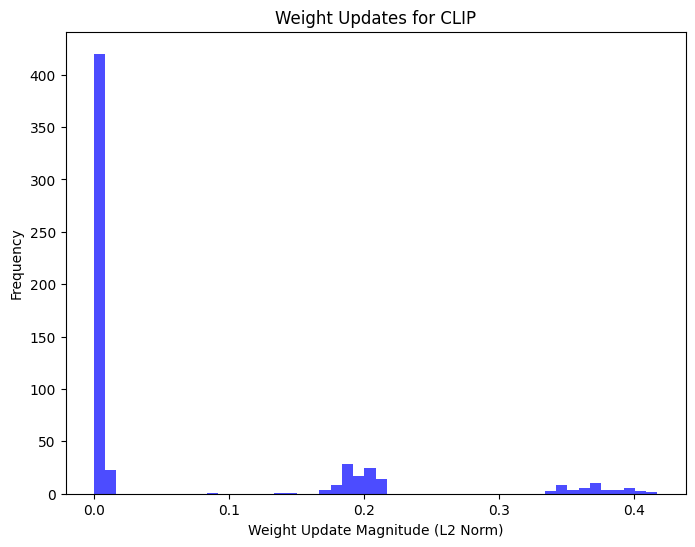

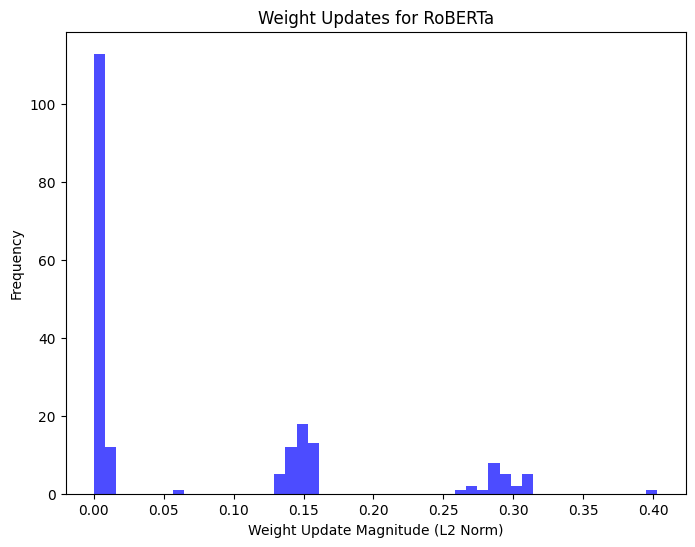

In [19]:
plot_weight_updates(weight_differences["clip"], "CLIP")
plot_weight_updates(weight_differences["roberta"], "RoBERTa")

In [18]:
def load_model(model_class, save_path, device, num_labels):

    model = model_class(num_labels=num_labels)
    model.load_state_dict(torch.load(save_path, map_location=device))
    model.to(device)
    model.eval()
    return model

def print_random_predictions(predictions, labels, label_order, num_samples=2):

    predictions = predictions.detach().cpu().numpy()
    labels = labels.cpu().numpy()

    indices = random.sample(range(len(predictions)), num_samples)

    for idx in indices:
        print(f"Sample {idx + 1}")
        print("True Labels:")
        for label, prob in zip(label_order, labels[idx]):
            print(f"  {label}: {prob:.4f}")
        print("Predicted Labels:")
        for label, prob in zip(label_order, predictions[idx]):
            print(f"  {label}: {prob:.4f}")
        print("-" * 40)

In [20]:
label_order = ["fear", "disgust", "joy", "surprise", "sadness", "anger"] 
save_path = "/work/ptyagi/masterthesis/models/multimodal_models/best_multimodal_model.pt"

# model = load_model(MultiModalClassifier, save_path, device, num_labels=len(label_order))

test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

batch = next(iter(test_loader))
images = batch["image"].to(device)
input_ids = batch["input_ids"].to(device)
attention_mask = batch["attention_mask"].to(device)
labels = batch["labels"].to(device)

with torch.no_grad():
    outputs = model(images, input_ids, attention_mask)
    predictions = torch.softmax(outputs, dim=-1) 

print_random_predictions(predictions, labels, label_order, num_samples=1)

Sample 6
True Labels:
  fear: 0.0120
  disgust: 0.2222
  joy: 0.3545
  surprise: 0.1523
  sadness: 0.0192
  anger: 0.2399
Predicted Labels:
  fear: 0.0597
  disgust: 0.0986
  joy: 0.4690
  surprise: 0.2086
  sadness: 0.0847
  anger: 0.0793
----------------------------------------


In [21]:
def evaluate_on_test_set(model, test_loader, device):
    model.eval()
    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for batch in test_loader:
            images = batch["image"].to(device)
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["labels"].to(device)

            outputs = model(images, input_ids, attention_mask)
            predictions = torch.softmax(outputs, dim=-1)

            all_predictions.append(predictions)
            all_labels.append(labels)

    all_predictions = torch.cat(all_predictions, dim=0)
    all_labels = torch.cat(all_labels, dim=0)

    return all_predictions, all_labels

def plot_cosine_similarity_kde(predictions, labels):

    similarities = F.cosine_similarity(predictions, labels, dim=-1).detach().cpu().numpy()

    plt.figure(figsize=(8, 6))
    sns.kdeplot(similarities, fill=True, color="blue")
    plt.title("Cosine Similarity Distribution")
    plt.xlabel("Cosine Similarity")
    plt.ylabel("Density")
    plt.axvline(x=1.0, color='green', linestyle='--', label='Perfect Similarity')
    plt.legend()
    plt.show()

def plot_label_wise_heatmap(predictions, labels, label_order):

    avg_pred = predictions.mean(dim=0).detach().cpu().numpy()
    avg_label = labels.mean(dim=0).cpu().numpy()

    heatmap_data = np.vstack([avg_label, avg_pred])
    row_labels = ["True", "Predicted"]

    plt.figure(figsize=(10, 4))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="coolwarm", xticklabels=label_order, yticklabels=row_labels)
    plt.title("Label-Wise Average Probabilities")
    plt.xlabel("Labels")
    plt.ylabel("")
    plt.show()




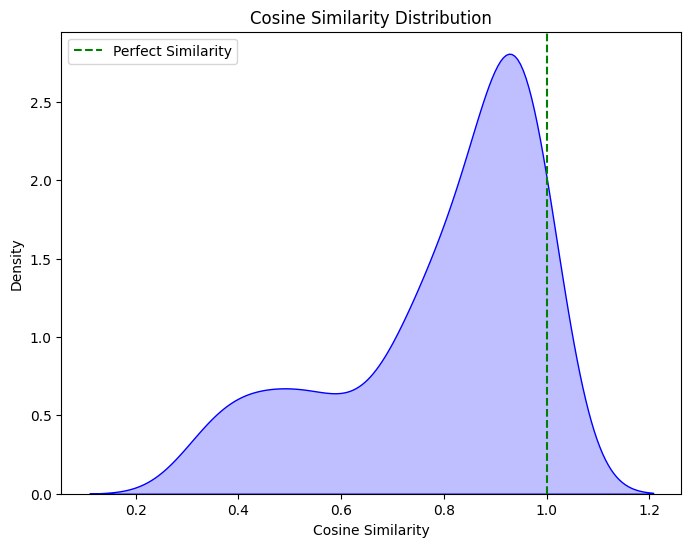

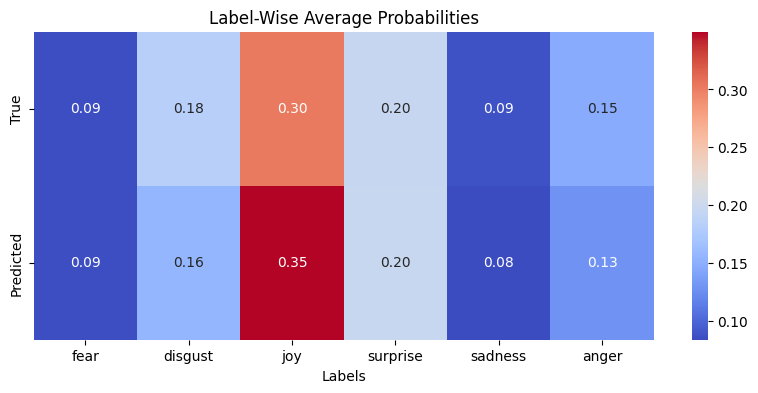

In [22]:
all_predictions, all_labels = evaluate_on_test_set(model, test_loader, device)

plot_cosine_similarity_kde(all_predictions, all_labels)

plot_label_wise_heatmap(all_predictions, all_labels, label_order)

FROZEN CLIP

In [24]:
model.freeze_clip()
model.to(device)

save_path = "/work/ptyagi/masterthesis/models/multimodal_models/frozen_clip_epochs2_base.pt"

train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=2, device=device, save_path=save_path, log_name="experiment_epochs2_frozen_clip_base")



Epoch 1/2 - Training:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 1/2 - Training: 100%|██████████| 147/147 [01:05<00:00,  2.23it/s, loss=0.189] 


Epoch 1/2 - Training Loss: 0.1257
Epoch 1/2 - Validation Metrics - KL Div: 0.4387, Cosine Sim: 0.7783, MSE: 0.0277
Model saved at /work/ptyagi/masterthesis/models/multimodal_models/frozen_clip_epochs2_base.pt


Epoch 2/2 - Training: 100%|██████████| 147/147 [01:02<00:00,  2.34it/s, loss=0.138] 


Epoch 2/2 - Training Loss: 0.1075
Epoch 2/2 - Validation Metrics - KL Div: 0.4401, Cosine Sim: 0.7804, MSE: 0.0280
Test Metrics - KL Div: 0.4831, Cosine Sim: 0.7432, MSE: 0.0306
Logs saved to runs/experiment_epochs2_frozen_clip_base


In [25]:
model.freeze_clip()
model.to(device)

save_path = "/work/ptyagi/masterthesis/models/multimodal_models/frozen_clip_epochs4_base.pt"

train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=4, device=device, save_path=save_path, log_name="experiment_epochs4_frozen_clip_base")

Epoch 1/4 - Training: 100%|██████████| 147/147 [01:02<00:00,  2.36it/s, loss=0.139] 


Epoch 1/4 - Training Loss: 0.0963
Epoch 1/4 - Validation Metrics - KL Div: 0.4404, Cosine Sim: 0.7842, MSE: 0.0278
Model saved at /work/ptyagi/masterthesis/models/multimodal_models/frozen_clip_epochs4_base.pt


Epoch 2/4 - Training: 100%|██████████| 147/147 [01:07<00:00,  2.17it/s, loss=0.0647]


Epoch 2/4 - Training Loss: 0.0883
Epoch 2/4 - Validation Metrics - KL Div: 0.4412, Cosine Sim: 0.7829, MSE: 0.0278


Epoch 3/4 - Training: 100%|██████████| 147/147 [01:06<00:00,  2.22it/s, loss=0.171] 


Epoch 3/4 - Training Loss: 0.0786
Epoch 3/4 - Validation Metrics - KL Div: 0.4317, Cosine Sim: 0.7832, MSE: 0.0274
Model saved at /work/ptyagi/masterthesis/models/multimodal_models/frozen_clip_epochs4_base.pt


Epoch 4/4 - Training: 100%|██████████| 147/147 [01:03<00:00,  2.30it/s, loss=0.114] 


Epoch 4/4 - Training Loss: 0.0696
Epoch 4/4 - Validation Metrics - KL Div: 0.4423, Cosine Sim: 0.7818, MSE: 0.0278
Test Metrics - KL Div: 0.4775, Cosine Sim: 0.7459, MSE: 0.0301
Logs saved to runs/experiment_epochs4_frozen_clip_base


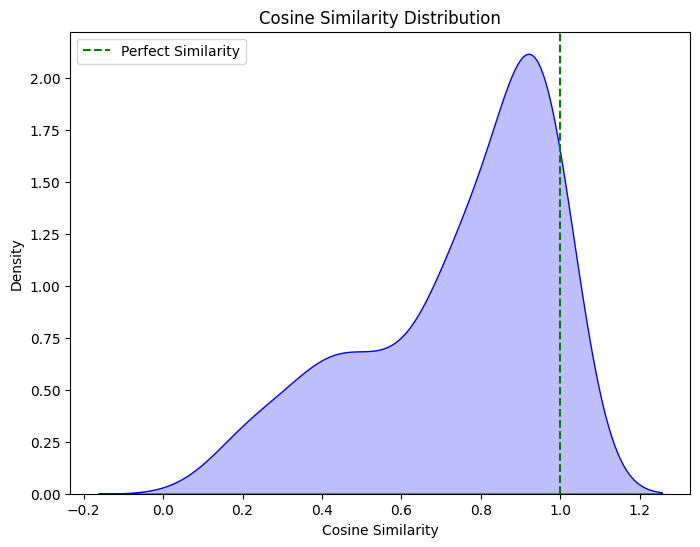

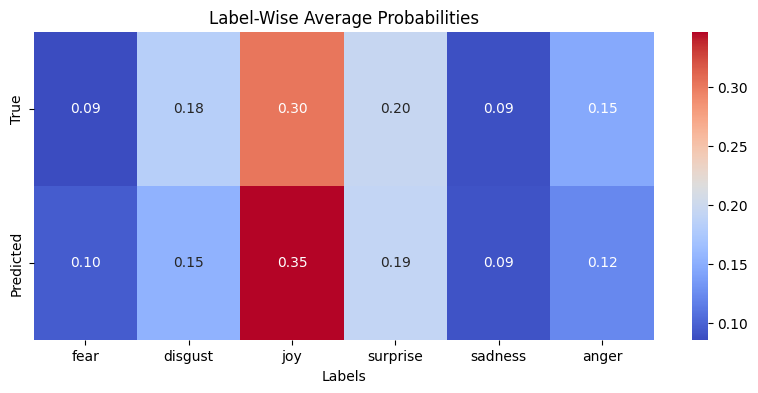

In [31]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
label_order = ["fear", "disgust", "joy", "surprise", "sadness", "anger"] 
all_predictions, all_labels = evaluate_on_test_set(model, test_loader, device)

plot_cosine_similarity_kde(all_predictions, all_labels)

plot_label_wise_heatmap(all_predictions, all_labels, label_order)

FROZEN ROBERTA

In [19]:
model.freeze_roberta()
model.to(device)

save_path = "/work/ptyagi/masterthesis/models/multimodal_models/frozen_roberta_epochs2.pt"

train_model(model, train_loader, val_loader, test_loader, criterion, optimizer, epochs=2, device=device, save_path=save_path, log_name="experiments_epochs2_frozen_roberta")

Epoch 1/2 - Training:   0%|          | 0/147 [00:00<?, ?it/s]

Epoch 1/2 - Training: 100%|██████████| 147/147 [01:35<00:00,  1.54it/s, loss=0.151]


Epoch 1/2 - Training Loss: 0.2322
Epoch 1/2 - Validation Metrics - KL Div: 0.3612, Cosine Sim: 0.8070, MSE: 0.0234
Model saved at /work/ptyagi/masterthesis/models/multimodal_models/frozen_roberta_epochs2.pt


Epoch 2/2 - Training: 100%|██████████| 147/147 [01:35<00:00,  1.55it/s, loss=0.167] 


Epoch 2/2 - Training Loss: 0.1505
Epoch 2/2 - Validation Metrics - KL Div: 0.3932, Cosine Sim: 0.7939, MSE: 0.0252
Test Metrics - KL Div: 0.3819, Cosine Sim: 0.7732, MSE: 0.0257
Logs saved to runs/experiments_epochs2_frozen_roberta


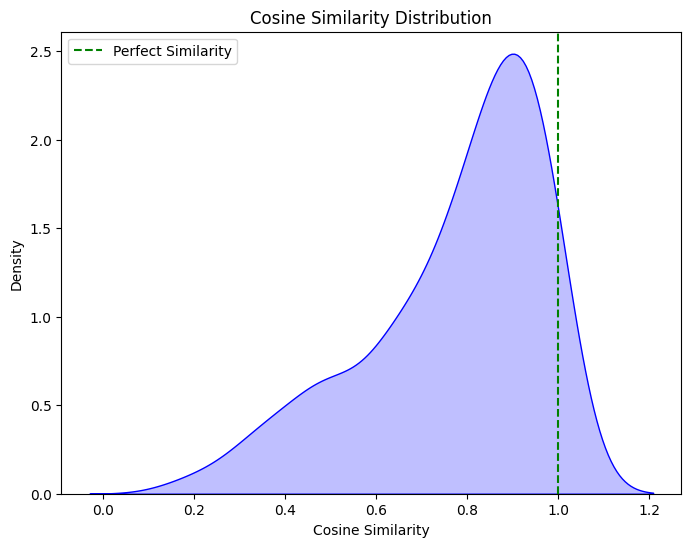

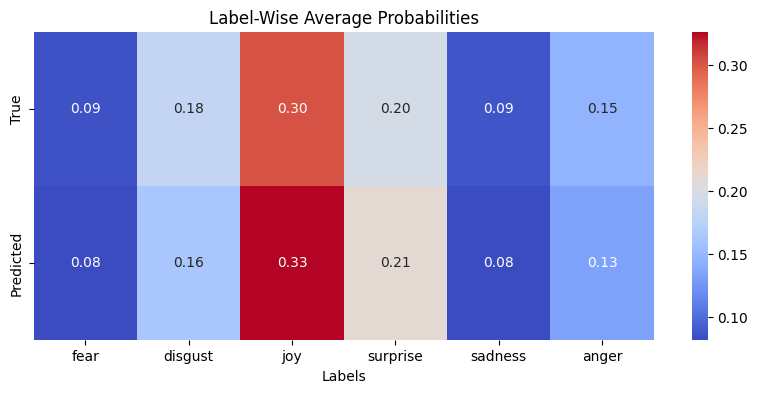

In [20]:
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)
label_order = ["fear", "disgust", "joy", "surprise", "sadness", "anger"] 
all_predictions, all_labels = evaluate_on_test_set(model, test_loader, device)

plot_cosine_similarity_kde(all_predictions, all_labels)

plot_label_wise_heatmap(all_predictions, all_labels, label_order)

In [6]:
dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

batch = next(iter(dataloader))

In [11]:
decoded_text = roberta_tokenizer.decode(batch["input_ids"][0], skip_special_tokens=True)

print("Decoded Text Input:", decoded_text)

Decoded Text Input: Our students took the lead in the fight against global warming today, as they took part in a series of activities and workshops inspired by the #ClimateStrike [URL] #makeadifference [URL]


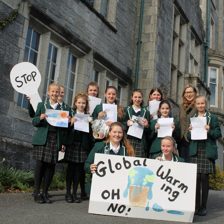

In [29]:
mean = torch.tensor([0.48145466, 0.4578275, 0.40821073])  # CLIP normalization mean
std = torch.tensor([0.26862954, 0.26130258, 0.27577711])  # CLIP normalization std
unnormalized_image = batch['image'].squeeze(0) * std[:, None, None] + mean[:, None, None]

pil_image = to_pil_image(unnormalized_image)
pil_image

In [7]:
import torch
from transformers import CLIPModel, AutoModel

# Define the architecture (same as when trained)
class MultiModalClassifier(nn.Module):
    def __init__(self, num_labels, hidden_dim=512):
        super(MultiModalClassifier, self).__init__()
        
        self.clip_model = CLIPModel.from_pretrained("openai/clip-vit-large-patch14")
        self.text_model = AutoModel.from_pretrained("cardiffnlp/twitter-roberta-base-emotion-latest")

        clip_feature_dim = self.clip_model.config.projection_dim  
        text_feature_dim = self.text_model.config.hidden_size
        combined_dim = clip_feature_dim + text_feature_dim

        self.mlp = nn.Sequential(
            nn.Linear(combined_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_dim, num_labels)
        )

    def forward(self, image, input_ids, attention_mask, return_intermediate_outputs=False):
        image_features = self.clip_model.get_image_features(image)
        text_outputs = self.text_model(input_ids=input_ids, attention_mask=attention_mask)
        text_features = text_outputs.last_hidden_state[:, 0, :]  # CLS token representation

        combined_features = torch.cat([image_features, text_features], dim=-1)
        logits = self.mlp(combined_features)

        if return_intermediate_outputs:
            return logits, image_features, text_features

        return logits

# Load model architecture and state dictionary
num_labels = 6  # Example number of labels
model = MultiModalClassifier(num_labels=num_labels)
model.load_state_dict(torch.load("/work/ptyagi/masterthesis/models/multimodal_models/best_multimodal_model_4epochs_base.pt"))
model.to(device)
model.eval()  # Set to evaluation mode



Some weights of RobertaModel were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base-emotion-latest and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipykernel_2244678/3505765403.py:39: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.se

MultiModalClassifier(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=7

In [10]:
dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

batch = next(iter(dataloader))

batch = {k: v.to(device) for k, v in batch.items()}

with torch.no_grad():
    logits, image_features, text_features = model(
        image=batch["image"],
        input_ids=batch["input_ids"],
        attention_mask=batch["attention_mask"],
        return_intermediate_outputs=True
    )

# Print outputs
print("Logits:", logits)
print("Image Features:", image_features)
print("Text Features:", text_features)

# If you need the ground truth labels for comparison
print("Ground Truth Labels:", batch["labels"])

Logits: tensor([[-1.0986, -0.1341,  1.4868,  0.3212, -0.7131, -0.3538]],
       device='cuda:7')
Image Features: tensor([[ 4.7061e-01,  7.8396e-01, -5.0073e-01,  3.0543e-02, -4.6300e-01,
          4.7597e-01, -1.5303e-01,  4.5558e-01, -6.9315e-01,  3.7442e-01,
         -2.6031e-01,  5.1593e-02,  7.0832e-01, -4.1830e-01,  4.1378e-01,
          1.2041e-01,  1.8312e-04, -4.8457e-01,  1.7030e-01,  5.4951e-01,
         -1.3201e-01, -1.8607e-01, -4.2316e-02, -4.8457e-01, -8.1624e-02,
          9.9681e-02, -2.6173e-01, -3.4456e-01,  3.0524e-01,  1.2023e+00,
         -5.1261e-01,  6.0244e-01,  1.0657e-02, -9.1990e-01, -8.8257e-02,
         -2.5566e-01, -5.9772e-01,  6.4142e-01, -1.2982e-01,  1.9320e-01,
          2.3398e-01,  3.7798e-01, -1.3171e-01,  5.2938e-02,  1.0299e+00,
         -4.2784e-01,  1.1634e-01,  7.9431e-01, -3.4872e-01,  2.3835e-02,
          3.9233e-01,  3.7307e-01, -6.2861e-01,  4.9772e-01, -2.9605e-01,
          1.2376e-01, -1.8645e-01,  1.5137e-02,  8.9460e-02,  6.6094e-01,

In [12]:
def extract_features(batch):
    with torch.no_grad():
        # Move batch to the correct device
        batch = {k: v.to(device) for k, v in batch.items()}
        
        # Extract image features
        image_features = model.clip_model.get_image_features(batch["image"])
        
        # Extract text features
        text_outputs = model.text_model(input_ids=batch["input_ids"], attention_mask=batch["attention_mask"])
        text_features = text_outputs.last_hidden_state[:, 0, :]  # CLS token representation
        
        return image_features, text_features, batch["labels"]

# Evaluate on test data
all_image_features = []
all_text_features = []
all_labels = []

for batch in dataloader:
    image_features, text_features, labels = extract_features(batch)
    
    # Store features and labels for later analysis
    all_image_features.append(image_features.cpu().numpy())
    all_text_features.append(text_features.cpu().numpy())
    all_labels.append(labels.cpu().numpy())

# Convert to numpy arrays for easier manipulation
import numpy as np
all_image_features = np.vstack(all_image_features)
all_text_features = np.vstack(all_text_features)
all_labels = np.vstack(all_labels)

# Analyze features
print("Image Features Shape:", all_image_features.shape)
print("Text Features Shape:", all_text_features.shape)
print("Labels Shape:", all_labels.shape)

Image Features Shape: (168, 768)
Text Features Shape: (168, 768)
Labels Shape: (168, 6)


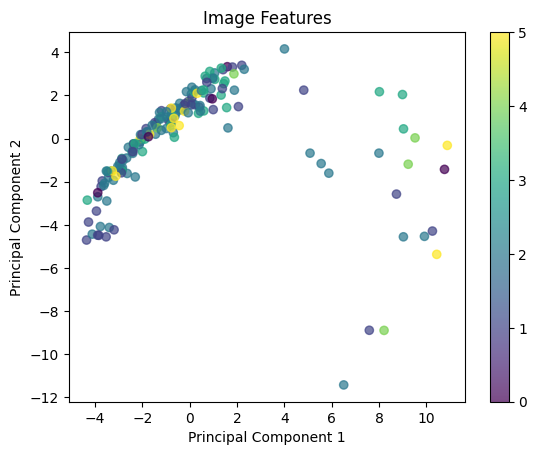

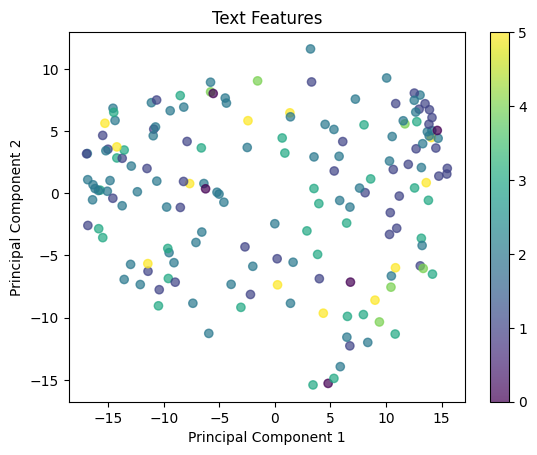

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

def visualize_features(features, labels, title="Feature Visualization"):
    pca = PCA(n_components=2)
    reduced_features = pca.fit_transform(features)
    plt.scatter(reduced_features[:, 0], reduced_features[:, 1], c=np.argmax(labels, axis=1), cmap='viridis', alpha=0.7)
    plt.colorbar()
    plt.title(title)
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.show()

# Visualize image features
visualize_features(all_image_features, all_labels, title="Image Features")

# Visualize text features
visualize_features(all_text_features, all_labels, title="Text Features")

In [15]:
from sklearn.metrics.pairwise import cosine_similarity
# Example: Similarity between first two samples for text features
similarity = cosine_similarity(all_text_features[:2])
print("Cosine Similarity (Text Features):", similarity)

# Example: Similarity between first two samples for image features
similarity = cosine_similarity(all_image_features[:2])
print("Cosine Similarity (Image Features):", similarity)

Cosine Similarity (Text Features): [[ 0.9999999  -0.03167551]
 [-0.03167551  1.0000001 ]]
Cosine Similarity (Image Features): [[1.0000002 0.9889785]
 [0.9889785 0.9999999]]


In [3]:
class ClipWithMLP(nn.Module):
    def __init__(self, model_name="openai/clip-vit-large-patch14", num_classes=6, hidden_size=512):
        super(ClipWithMLP, self).__init__()
        self.clip_model = CLIPModel.from_pretrained(model_name)
        self.mlp = nn.Sequential(
            nn.Linear(self.clip_model.config.projection_dim, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(hidden_size, num_classes)
        )


    def forward(self, image):
        image_features = self.clip_model.get_image_features(image)
        logits = self.mlp(image_features)
        return logits

In [19]:
model= ClipWithMLP()

In [7]:
model

ClipWithMLP(
  (clip_model): CLIPModel(
    (text_model): CLIPTextTransformer(
      (embeddings): CLIPTextEmbeddings(
        (token_embedding): Embedding(49408, 768)
        (position_embedding): Embedding(77, 768)
      )
      (encoder): CLIPEncoder(
        (layers): ModuleList(
          (0-11): 12 x CLIPEncoderLayer(
            (self_attn): CLIPSdpaAttention(
              (k_proj): Linear(in_features=768, out_features=768, bias=True)
              (v_proj): Linear(in_features=768, out_features=768, bias=True)
              (q_proj): Linear(in_features=768, out_features=768, bias=True)
              (out_proj): Linear(in_features=768, out_features=768, bias=True)
            )
            (layer_norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (mlp): CLIPMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=768, out_features=3072, bias=True)
              (fc2): Linear(in_features=3072, out_features=768, bias=

In [20]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {total_params}")

Number of trainable parameters: 428013319


In [8]:
class CLIPFineTuner(nn.Module):
    def __init__(self, model, num_classes):
        super(CLIPFineTuner, self).__init__()
        self.model = model
        self.classifier = nn.Linear(model.visual.output_dim, num_classes)
    
    def forward(self, x):
        with torch.no_grad():
            features = self.model.encode_image(x).float()  # Convert to float32
        return self.classifier(features)

In [10]:
import clip

In [15]:
model, preprocess = clip.load("ViT-L/14", jit=False)

100%|███████████████████████████████████████| 890M/890M [00:46<00:00, 20.0MiB/s]


In [16]:
model = CLIPFineTuner(model, 6)

In [17]:
model

CLIPFineTuner(
  (model): CLIP(
    (visual): VisionTransformer(
      (conv1): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (ln_pre): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (transformer): Transformer(
        (resblocks): Sequential(
          (0): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
            )
            (ln_1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
            (mlp): Sequential(
              (c_fc): Linear(in_features=1024, out_features=4096, bias=True)
              (gelu): QuickGELU()
              (c_proj): Linear(in_features=4096, out_features=1024, bias=True)
            )
            (ln_2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          )
          (1): ResidualAttentionBlock(
            (attn): MultiheadAttention(
              (out_proj): NonDynamically

In [18]:
total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of trainable parameters: {total_params}")

Number of trainable parameters: 427621127


In [4]:
model = CLIPModel.from_pretrained("/work/ptyagi/masterthesis/src/models/multimodal_experiments_february/exp_only_clip_lr1e-5_epochs2_seed42/best_model.pt")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-large-patch14")
model.to(device)
image = Image.open("/work/ptyagi/masterthesis/data/test/images/id_1096494783256846339_2019-02-15.jpg")

inputs = processor(text=["fear", "disgust", "joy", "surprise", "sadness", "anger"] , images=image, return_tensors="pt", padding=True)
inputs.to(device)
outputs = model(**inputs)
logits_per_image = outputs.logits_per_image  # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1)

OSError: Incorrect path_or_model_id: '/work/ptyagi/masterthesis/src/models/multimodal_experiments_february/exp_only_clip_lr1e-5_epochs2_seed42/best_model.pt'. Please provide either the path to a local folder or the repo_id of a model on the Hub.

In [4]:
file_path = "/work/ptyagi/masterthesis/data/predictions/aug/averaged_predictions.csv" 

data = pd.read_csv(file_path)
    
train_data, temp_data = train_test_split(data, test_size=0.3, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=1/3, random_state=42)

In [5]:
test_data.head()

,conversation_id,tweet_text,roberta-large-predictions,averaged_predictions,mapped_predictions,cosine_similarity_tweet_replies,clip_predictions,cosine_similarity_clip_replies,cosine_similarity_clip_tweet,similarity_bin,matched_filename
5939,1166008123263475712,#AlTenoorOverflow #Africafires#Angola#Zambia#T...,"[('anticipation', 0.18425847589969635), ('ange...","[('anger', 0.06943728003861536), ('fear', 0.48...","[('anger', 0.21514055782994462), ('fear', 0.15...",0.549003,"[('fear', 0.3789367), ('anger', 0.26606992), (...",0.805413,0.782031,0.6-0.8,id_1166008123263475712_2019-08-26.jpg
763,1158024573243334657,Sage words from co-founder of the [USER] [USER...,"[('disgust', 0.9435292482376099), ('anger', 0....","[('anger', 0.12345011625812803), ('fear', 0.11...","[('anger', 0.3335972931162361), ('fear', 0.058...",0.741571,"[('surprise', 0.3979619), ('disgust', 0.192632...",0.718972,0.667360,0.6-0.8,id_1158024573243334657_2019-08-04.jpg
3308,1161462789795221504,So I know they are #ClimateChangedeniers.But I...,"[('disgust', 0.9702249765396118), ('anger', 0....","[('anger', 0.2677825772720873), ('fear', 0.104...","[('anger', 0.33216690109041486), ('fear', 0.12...",0.970299,"[('surprise', 0.39039624), ('anger', 0.3012097...",0.632252,0.620269,0.6-0.8,id_1161462789795221504_2019-08-14.jpg
3994,1163191441306398721,Is Climate Change real? That’s not up to us to...,"[('anticipation', 0.9576886892318726), ('optim...","[('anger', 0.15045814225567147), ('fear', 0.07...","[('anger', 0.08089625640880886), ('fear', 0.07...",0.938699,"[('anger', 0.45440218), ('disgust', 0.20690694...",0.622256,0.432749,0.4-0.6,id_1163191441306398721_2019-08-18.jpg
4814,1164233724772462592,Why isn’t everyone doing this?[URL] [USER] #cl...,"[('optimism', 0.792866587638855), ('sadness', ...","[('anger', 0.12882927371328437), ('fear', 0.17...","[('anger', 0.0580449479990004), ('fear', 0.028...",0.838172,"[('anger', 0.5921461), ('sadness', 0.21181808)...",0.565835,0.321836,0.2-0.4,id_1164233724772462592_2019-08-21.jpg


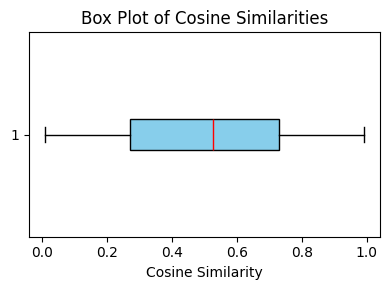

In [8]:
plt.figure(figsize=(4, 3))
plt.boxplot(test_data['cosine_similarity_clip_replies'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
plt.title('Box Plot of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.tight_layout()
plt.show()

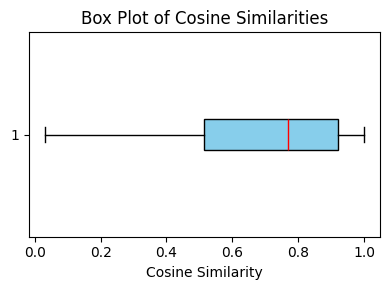

In [9]:
plt.figure(figsize=(4, 3))
plt.boxplot(test_data['cosine_similarity_tweet_replies'], vert=False, patch_artist=True,
            boxprops=dict(facecolor='skyblue', color='black'),
            medianprops=dict(color='red'))
plt.title('Box Plot of Cosine Similarities')
plt.xlabel('Cosine Similarity')
plt.tight_layout()
plt.show()

In [28]:
df = pd.read_csv("/work/ptyagi/masterthesis/data/tmp/tweet_replies_aug_2019.csv")

In [30]:
tmp1 = df.query("conversation_id == 1161462789795221504")

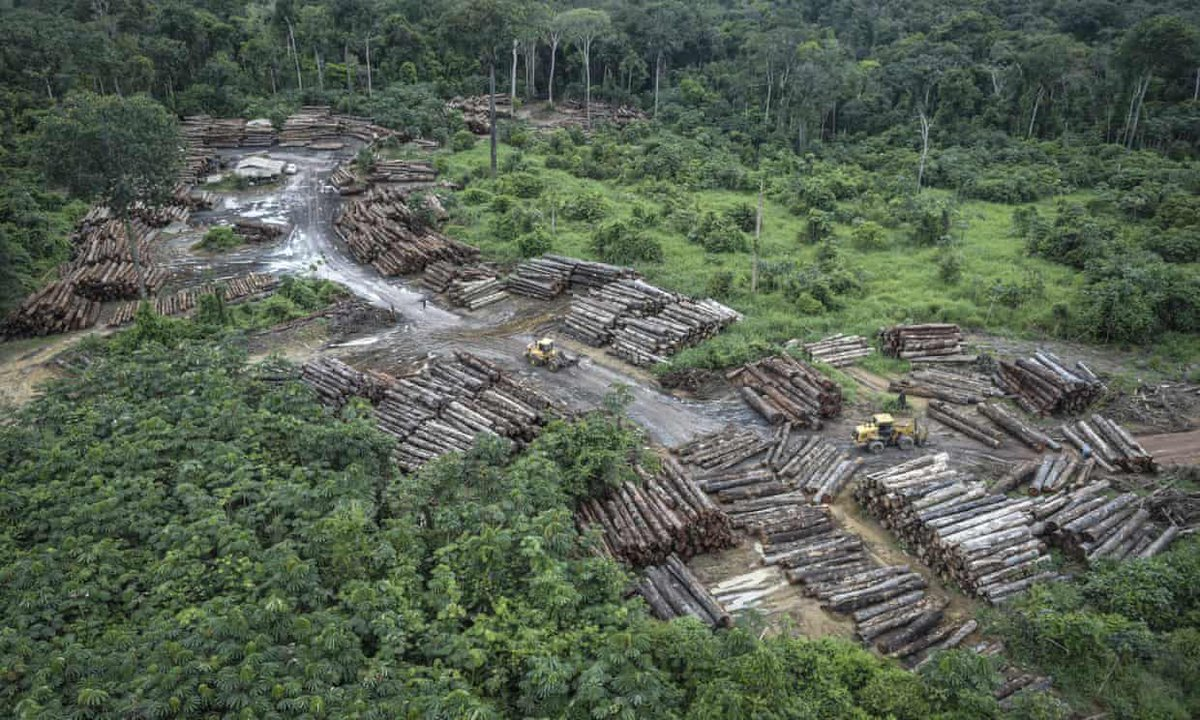

In [11]:
path = "/work/ptyagi/ClimateVisions/Images/2019/08_August/id_1161462789795221504_2019-08-14.jpg"
image = Image.open(path)
image

In [15]:
tmp = test_data.query("conversation_id == 1161462789795221504")

In [20]:
print(tmp['tweet_text'].iloc[0])

So I know they are #ClimateChangedeniers.But I will suggest you look around to what is destroying our #planet. Other than the #lack of leadership??#Greed.#Greed for #Oil.#Greed for #MoneyAnd #Deforestation.#fossilfree #ClimateChange#Rainforest#JairBolsonaro#AlGore [URL]


In [32]:
print(tmp1['replies'].iloc[0])

thank yousharing please enlighten us on what is the farce nope is very real amp your pres is not helpingtackle is responsible for this atrocity own it my dear history will speak accordingly


In [34]:
print(tmp1['replies'].iloc[2])

u are speaking like a truly and a sorry to hear that if i may please look around uwill see how are melting on are rising droughts and flooding and heatwave all over the egulates our


In [33]:
print(tmp1['replies'].iloc[1])

sorry to hear the bells of ignorance from you usually expected wake up is here like it or not and this got nothing to do with politics is a reality amp we all are suffering cause of that change your mind and change your world amigo no to


In [36]:
print(tmp['roberta-large-predictions'].iloc[0])

[('disgust', 0.9702249765396118), ('anger', 0.9526081085205078), ('sadness', 0.5032250881195068), ('pessimism', 0.25362253189086914), ('fear', 0.10858986526727676), ('anticipation', 0.03798331692814827), ('optimism', 0.02562788501381874), ('trust', 0.0063927993178367615), ('surprise', 0.004614512901753187), ('love', 0.0027436271775513887), ('joy', 0.002227106364443898)]


In [22]:
print(tmp['mapped_predictions'].iloc[0])

[('anger', 0.33216690109041486), ('fear', 0.12630059352256895), ('surprise', 0.014853525811102821), ('disgust', 0.3383097634117454), ('sadness', 0.17547060178945453), ('joy', 0.012898614374713402)]


In [21]:
print(tmp['averaged_predictions'].iloc[0])

[('anger', 0.2677825772720873), ('fear', 0.10465799783353473), ('surprise', 0.047283146898703936), ('disgust', 0.2885787136270385), ('sadness', 0.2641371961918088), ('joy', 0.027560368176826635)]


In [23]:
print(tmp['clip_predictions'].iloc[0])

[('surprise', 0.39039624), ('anger', 0.3012097), ('disgust', 0.11028163), ('fear', 0.09690402), ('sadness', 0.07113794), ('joy', 0.030070437)]
